# Building a CORD19 Research Engine

In this notebook we build a **CORD Research Engine** on top of a **BM25** search index, along with a full document **Similarity Index** by storing the 786 dimension **Specter Vectors** in an **Annoy** index. Both these indexes complement each other - **BM25** is unmatched for search while the Specter Vectors provide unprecedented accuracy in similarity matching.

These indexes are complemented an intuitive user interface - both with an **interactive Search Bar** as well as a natural language like Python API `papers.similar_to`, all running within a notebook. The combination of these features pushes the boundary of what can be achieved in notebooks in terms of speed of information retrieval, assembly and publication. This is shown in the <a href="#Task-Notebooks">9 task specific notebooks</a> created with the help of the CORD Research Engine.

Of course the entire point to to provide insights into how to fight the SARS-COV2 pandemic, and we prioritize the surfacing of actionable research in this main notebook and in the task specific notebooks. The code for the engine is also available on github as will be explained below.

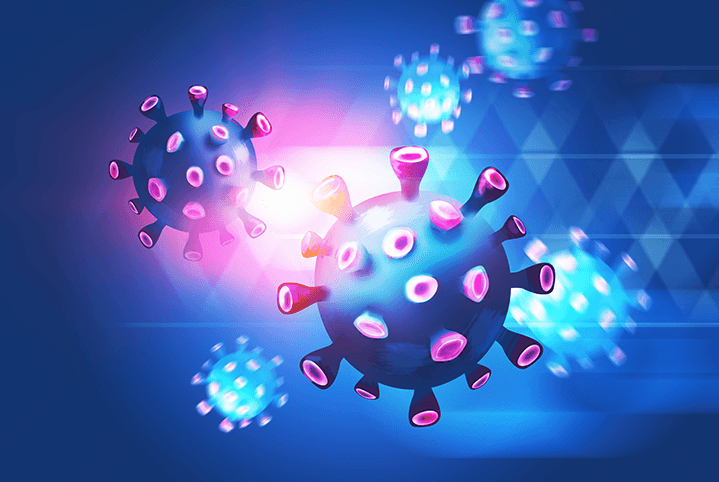

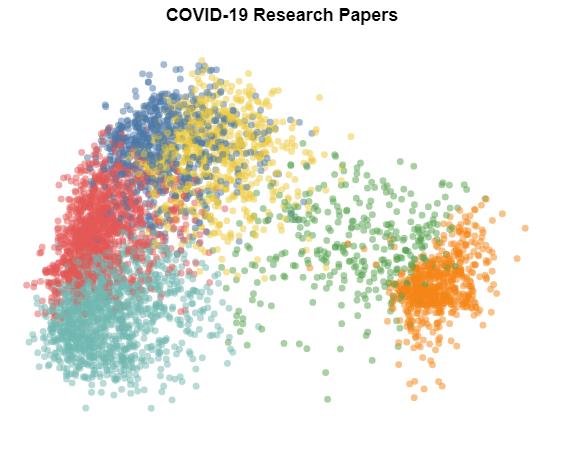

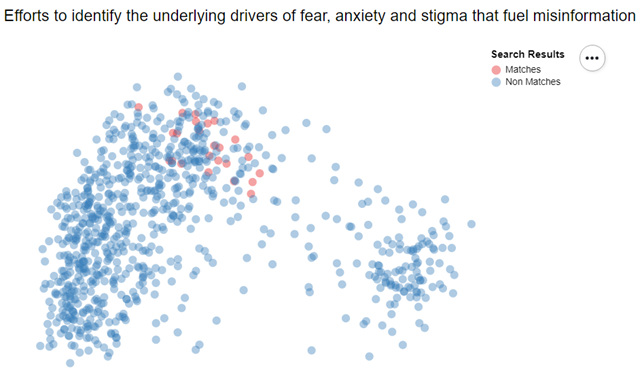

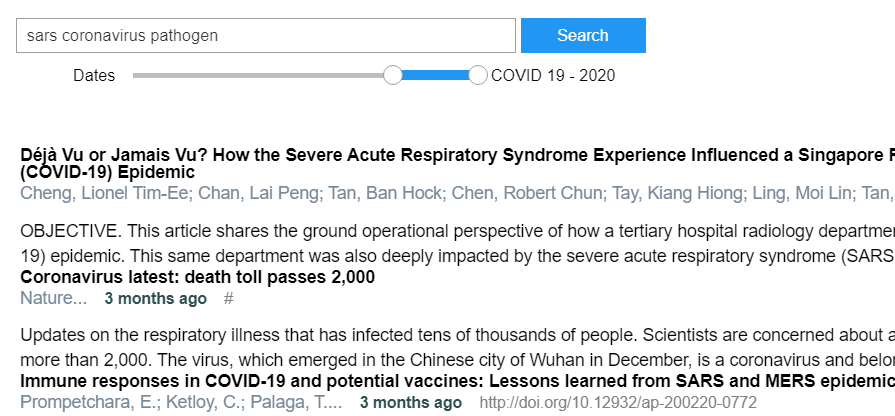

# Task Notebooks

This notebook is used as the base for the following Task notebooks

<a href="https://www.kaggle.com/dgunning/transmission-incubation-and-environment-stability" target="_blank">1. What is known about transmission, incubation, and environmental stability?</a>

<a href="https://www.kaggle.com/dgunning/what-do-we-know-about-covid-19-risk-factors" target="_blank">2. What do we know about COVID-19 risk factors?</a>

<a href="https://www.kaggle.com/dgunning/what-we-know-about-genetics-origin-and-evolution" target="_blank">3. What do we know about virus genetics, origin, and evolution?</a>

<a href="https://www.kaggle.com/dgunning/what-we-know-about-vaccines-and-therapeutics" target="_blank">4. What do we know about vaccines and therapeutics?</a>

<a href="https://www.kaggle.com/dgunning/what-we-know-about-medical-care" target="_blank">5. What has been published about medical care?</a>

<a href="https://www.kaggle.com/dgunning/current-research-nonpharmaceutical-interventions" target="_blank">6. What do we know about non-pharmaceutical interventions?</a>

<a href="https://www.kaggle.com/dgunning/current-research-on-diagnostics-and-surveillance" target="_blank">7. What do we know about diagnostics and surveillance?</a>

<a href="https://www.kaggle.com/dgunning/what-we-know-about-social-and-ethical-concerns" target="_blank">8. What has been published about ethical and social science considerations?</a>

<a href="https://www.kaggle.com/dgunning/cord-research-on-information-sharing" target="_blank">9. What has been published about information sharing and inter-sectoral collaboration?</a>

## Table of Contents

<a href="#1.--Installing-the-dgunning/cord19-Library">1. Installing the cord library</a>

<a href="#2.--Loading-Research-Papers">2. Loading Research Papers</a>

<a href="#3.-Searching-Research-Papers">3. Searching Research Papers</a>

&nbsp;&nbsp;<a href="#With-the-search-function">  With the search function</a>

&nbsp;&nbsp;<a href="#With-the-searchbar">  With the searchbar</a>

<a href="#4.-Selecting-Research-Papers">4. Selecting Research Papers</a>

<a href="#5.-Selecting-Individual-Papers">5. Selecting Individual Papers</a>

<a href="#6.-Exploratory-Analysis-and-Charts">6. Exploratory Analysis and Charts</a>

<a href="#7.-Technical-Notes">7. Technical Notes</a>

&nbsp;&nbsp;<a href="#What-is-BM25">  What is BM25</a>

&nbsp;&nbsp;<a href="#Preprocessing-Text">  Preprocessing Text</a>

&nbsp;&nbsp;<a href="#Loading-JSON">  Loading JSON</a>

&nbsp;&nbsp;<a href="#Parallel-Processing-Code">  Parallel Processing Code</a>





# 1.  Installing the dgunning/cord19 Library

The code for this kernel is maintained at https://github.com/dgunning/cord19. To install it in the Kaggle kernel, the Internet must be set to ON.

In [ ]:
!pip install -U git+https://github.com/dgunning/cord19.git

# Technical Design Notes
For current details on the design of the **cord** library, check the project on [github/dgunning/cord19](https://github.com/dgunning/cord19)

The **ResearchPapers** class is a container for the metadata, and the BM25 search index. It contains functions to find papers using **index** `research_papers[0]`,  **cord_uid** `research_papers["4nmc356g"]`, **OR** to create subsets of ResearchPapers like `papers.since_sarscov2`, **OR** to run `search()` or display the `searchbar()`

Because the ResearchPapers class is simply a container for the metadata dataframe, and all useful information about each paper is on the dataframe as a column, including the **index_tokens**, tags such as **covid_related** etc, subsetting ResearchPapers is simply a matter of subsetting the **metadata** dataframe, then creating a new ResearchPapers instance. To create a ResearchPapers instance after a date means 
```{python}
    def after(self, date, include_null_dates=False):
        cond = self.metadata.published >= date
        if include_null_dates:
            cond = cond | self.metadata.published.isnull()
        return self._make_copy(self.metadata[cond])
```
Thus, we implement functions such as **head**, **tail**, **sample**, **query**, which just delegate to the metadata dataframe function and then create a new ResearchPapers instance.

## What happens in ResearchPapers.load?
1. **load_metadata** - Load the **metadata.csv** file
```python
@staticmethod
    def load_metadata(data_path=None):
        if not data_path:
            data_path = find_data_dir()

        print('Loading metadata from', data_path)
        metadata_path = PurePath(data_path) / 'metadata.csv'
        dtypes = {'Microsoft Academic Paper ID': 'str', 'pubmed_id': str}
        renames = {'source_x': 'source', 'has_full_text': 'has_text'}
        metadata = pd.read_csv(metadata_path, dtype=dtypes, low_memory=False,
                               parse_dates=['publish_time']).rename(columns=renames)
```
2. **clean_metadata** - Clean the metadata
```python
def clean_metadata(metadata):
    print('Cleaning metadata')
    return metadata.pipe(start) \
        .pipe(clean_title) \
        .pipe(clean_abstract) \
        .pipe(rename_publish_time) \
        .pipe(add_date_diff) \
        .pipe(drop_missing) \
        .pipe(fill_nulls) \
        .pipe(apply_tags)
```

3. **Create the BM25 Search Index**

**ResearchPapers** can be indexed with the metadata *abstracts* OR with the *text* content of the paper. Indexing from the abstracts is straightforward - we just apply a **preprocess** function to clean and tokenize the abstract. Indexing from the texts - if no json-cache exists - happens by loading the JSON files and, tokenizing the texts and setting the **index_tokens** on the metadata. However, there is now a **json_cache** dataset comprised of the preprocessed text tokens, along with the JSOn file's sha - which we use to merge into the metadata.

After the metadata is loaded and cleaned we create the **BM25** index inside of **ResearchPapers.__init__()**

```python
      
if 'index_tokens' not in metadata:
    print('\nIndexing research papers')
    if any([index == t for t in ['text', 'texts', 'content', 'contents']]):
        _set_index_from_text(self.metadata, data_dir)
    else:
        print('Creating the BM25 index from the abstracts of the papers')
        print('Use index="text" if you want to index the texts of the paper instead')
        tick = time.time()
        self.metadata['index_tokens'] = metadata.abstract.apply(preprocess)
        tock = time.time()
        print('Finished Indexing in', round(tock - tick, 0), 'seconds')

```

## Creating Document Vectors
Creating document vectors is simple. First we load the cached JSON tokens. (This is a cached version of the JSON files optimized for memory and disk space)

```python
json_tokens = []
for catalog in JSON_CATALOGS:
    json_cache = load_json_cache(catalog)
    json_tokens.append(json_cache)
    
json_tokens = pd.concat(json_tokens, ignore_index=True)
```

then we train a **gensim Doc2Vec** model to create vectors with length **VECTOR_SIZE** (currently 20)

```python
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(json_tokens.index_tokens)]
model = Doc2Vec(documents, vector_size=VECTOR_SIZE, window=2, min_count=1, workers=8)
```
Next we can create a document vector for each json record

```python
json_tokens['document_vector'] = json_tokens.index_tokens.apply(model.infer_vector)
```

### Document Similarity Index
The document similarity index is based on [Annoy](https://github.com/spotify/annoy). Annoy is very simple and super fast, and will return the mst similar items to a given query.

```python
from annoy import AnnoyIndex

annoy_index = AnnoyIndex(DOCUMENT_VECTOR_LENGTH, 'angular')  
for i in range(len(metadata)):
    v = json_tokens.loc[i].document_vector
    annoy_index.add_item(i, v)

annoy_index.build(10) # 10 trees
```

# 2. Loading Research Papers

In [ ]:
from cord import ResearchPapers

research_papers = ResearchPapers.load()

# 3. Searching Research Papers

The ResearchPapers instance provides two main ways of searching - using the function **search()** or using the function **searchbar()** which will show an interactive search bar. 





### With the search function

The ResearchPapers class has a function **search** in which you can specify search terms. The function will use the **BM25** index to retrieve the documents that most closely satisfy the search

In [ ]:
research_papers.search('antiviral treatment')

### With the searchbar
You can call searchbar() without any arguments to show the widget without any initial search results, or with an initial search string, which we will do below.

In [ ]:
research_papers.searchbar('antiviral treatment')

# 4. Selecting Research Papers

There are many ways to select subsets of research papers including

- **Papers since SARS**  `research_papers.since_sars()`
- **Papers since SARS-COV-2** `research_papers.since_sarscov2()`
- **Papers before SARS** `research_papers.before_sars()`
- **Papers before SARS-COV-2** `research_papers.before_sarscov2()`
- **Papers before a date** `research_papers.before('1989-09-12')`
- **Papers after a date** `research_papers.after('1989-09-12')`
- **Papers that contains a string** 
- **Papers that match a string (using regex)** 

Here we are interested in research papers since the sars-cov-2 outbreak

### Research papers since SARS-COV-2

In [ ]:
since_covid = research_papers.since_sarscov2()
since_covid

### Research Papers that match the H{num}N{num} pattern
The code below returns papers that match the regex "H[0-9]N[0-9]"

In [ ]:
research_papers.match('H[0-9]N[0-9]')

### Match string columns
To select research papers that match on a string column, use `research_papers.match(<searchstring>)`. If no column is specified, then the abstract is used.

The following shows what has been published by **Anthony Fauci** since the SARS-COV-2 outbreak

In [ ]:
research_papers.contains("Fauci", column='authors').since_sarscov2()

# 5. Selecting Individual Papers
Individual papers can be selected from the ResearchPapers instance using the **[]** selectors, using the index number of the paper. Note that you will likely never know the index value of the paper that you need, but this ability will come in handy when using the search tool.

### Selecting a paper by index
You can select any paper in the **ResearchPapers** instance using the index. This will locate and create a new **Paper** instance, which you can output to the notebook.

In [ ]:
paper = research_papers[197]
paper

### Selecting a paper by cord_uid
You can also select a paper using its **cord_uid**.

In [ ]:
paper = research_papers['asf5c7xu'] # or research_papers['5c31897d01f3edc7f58a0f03fceec2373fcfdc3d']
paper

This would be similar to querying research_papers for a single sha, but in this case a **ResearchPapers** instance is returned.

In [ ]:
research_papers.query("sha=='5c31897d01f3edc7f58a0f03fceec2373fcfdc3d'")

### Viewing a Research Paper
Once you have a research paper, there are many ways to view it.

- **Overview** A nicely formatted view of the paper's important fields
- **Abstract** The paper's abstract
- **Summary** A summary of the paper's abstract using the **TextRank** algorithm
- **Text** The text the paper
- **HTML** The contents of the paper as somewhat nicely formatted HTML
- **Text Summary** The text of the paper, summarized using the **TextRank** algorithm

In [ ]:
from ipywidgets import interact
from IPython.display import display

paper = research_papers['asf5c7xu']

def view_paper(ViewPaperAs):
    if ViewPaperAs == 'Overview':
        display(paper)
    elif ViewPaperAs == 'Abstract':
        display(paper.abstract)
    elif ViewPaperAs == 'Summary of Abstract':
        display(paper.summary)
    elif ViewPaperAs == 'HTML':
        display(paper.html)
    elif ViewPaperAs == 'Text':
        display(paper.text)
    elif ViewPaperAs == 'Summary of Text':
        display(paper.text_summary)
    
interact(view_paper,
         ViewPaperAs=['Overview', # Show an overview of the paper's important fields and statistics
                      'Abstract', # Show the paper's abstract
                      'Summary of Abstract', # Show a summary of the paper's abstract
                      'HTML', # Show the paper's contents as (slightly) formatted HTML
                      'Text', # Show the paper's contents
                      'Summary of Text' # Show a summary of the paper's content
                     ]
        );

### Finding Similar Papers

In [ ]:
research_papers.similar_to('asf5c7xu')

### Widgets in Jupyter notebook
The code above also show how to use **ipywidgets interact** and **IPython display** to provide a userinterface inside a Jupyter notebook. 

# 6. Exploratory Analysis and Charts

### Load Document Vectors

Each research paper's content was converted to a document vector using **gensim's Doc2Vec**. We load the document vectors and filter out any empty vectors. (We have some empty vectors where the research paper was not associated with any JSON content)

In [ ]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from cord.core import cord_support_dir

# Load the document vectors
vectors = pd.read_parquet(cord_support_dir()/ 'DocumentVectors.pq').reset_index()
display(widgets.HTML('<h4>Document Vectors</h4>'))
display(vectors.head())

# Use the metadata of the research_papers
metadata = research_papers.metadata.copy()

vector_metadata_merge = vectors.merge(metadata, on='cord_uid', how='right')
vectors['covid_related'] = vector_metadata_merge.covid_related
vectors['published'] = vector_metadata_merge.published
display(widgets.HTML('<h4>Document Vectors with covid_related and published</h4>'))
display(vectors.head())

### Chart showing clusters of research papers
The chart below shows the research papers in 2D space. The chart below is done in **Altair** - the best Python charting library.

In [ ]:
import altair as alt


vector_df = pd.DataFrame({'x':vectors.x,
                          'y': vectors.y,
                          '1d': vectors['1d'],
                          'cluster': vectors.cluster,
                          'covid_related': vectors.covid_related,
                          'published': vectors.published})  # Ensure 5000 limit

alt.Chart(vector_df.sample(5000)).mark_point().encode(
       x=alt.X('x', axis=None),
       y=alt.Y('y', axis=None),
       color= 'cluster:N'
    ).properties(
        title='CORD Research Papers in 2D space',
        width=600,
        height=400
    ).configure_axis(
        grid=False
    ).configure_view(
        strokeWidth=0
    )

### Identify which clusters are covid related

In [ ]:
import matplotlib.style as style
style.use('fivethirtyeight')
covid_count = vector_df[['cluster', 'covid_related']].groupby(['cluster']).sum() 
cluster_count = vector_df[['cluster', 'covid_related']].groupby(['cluster']).count() 
covid_cluster_stats = (covid_count / cluster_count) * 100
covid_cluster_stats = covid_cluster_stats.sort_values(['covid_related'])
fig = covid_cluster_stats.plot.barh(grid=False, figsize=(6, 3), legend=False, title='% Covid Related');

### Research Papers since COVID

We plot the 1d compression of the 768-dimension document vector over time, with the clusters identified by color. Then we plot clusters 2 and 6. We see a big increase in the number of papers since COVID appeared

In [ ]:
vector_since = vector_df.query('published > "2015-01-01" & (cluster==2 | cluster==6)').copy()
vector_since.loc[vector_since.published> '2020-06-30', 'published'] = pd.to_datetime('2020-03-30')
if len(vector_since) > 5000:
    vector_since = vector_since.sample(5000)
alt.Chart(vector_since).mark_point().encode(
       x=alt.X('published:T'),
       y=alt.Y('1d'),
       color= 'cluster:N'
    ).properties(
        title='CORD Research Papers since 2015',
        width=600,
        height=400
    ).configure_axis(
        grid=False
    ).configure_view(
        strokeWidth=0
    )

### New Feature - 2D Visual Search

In [ ]:
query ="""
Efforts to identify the underlying drivers of fear, anxiety and stigma that
fuel misinformation and rumor, particularly through social media.
"""
research_papers.search_2d(query)

# 7. Technical Notes
What follows here will be a discussion of the technical design of the CORD library with code snippets

## What is BM25

**BM25** stands for **Best Match the 25th iteration** and is a text search algorithm first developed in 1994. It is one of the best search algorithms available, and **Lucene**, and its derivatives **Solr** and **ElasticSearch** switched to a **BM25** variant around 2015.

### Creating a simple BM25 index
To show how to create a BM25 index, we will first load the metadata, and just use a subset of the columns and the rows

In [ ]:
import pandas as pd
import numpy as np
from rank_bm25 import BM25Okapi
pd.options.display.max_colwidth=160

meta_df = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv') # Or pd.read_csv()
meta_df = meta_df[['title', 'abstract', 'publish_time']].head(1000)
meta_df

### Preprocessing Text
To create the index, we need a list of the tokens in each string. The easiest way to do so is by using **gensim** or **NLTK** to tokenize each abstract into a list of tokens. Here we use **gensim**

In [ ]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string

meta_df_tokens = meta_df.abstract.fillna('').apply(preprocess_string)

Now we create a **BM25Okapi** index from the tokens. We also implement a search function that returns the top 10 results from the search.
Note that in search wer are asking the index to return the dataframe indexes of the tokens most similar to the search string.

In [ ]:
from rank_bm25 import BM25Okapi
import numpy as np

bm25_index = BM25Okapi(meta_df_tokens.tolist())

def search(search_string, num_results=10):
    search_tokens = preprocess_string(search_string)
    scores = bm25_index.get_scores(search_tokens)
    top_indexes = np.argsort(scores)[::-1][:num_results]
    return top_indexes

indexes = search('novel coronavirus treatment')
indexes

You can use the indexes to locate the rows in **meta_df** which best match the search terms

In [ ]:
meta_df.loc[indexes, ['abstract', 'publish_time']]

Or use the search function directly in **meta_df.loc[]**

In [ ]:
meta_df.loc[search('novel coronavirus treatment')]

## Parallel Processing Code
Creating the BM25 index from the contents of over 44000 research papers requires running the preprocessing and tokenization in parallel. The following code includes a function called **parallel** which applies a function over a Collection. The parallel function is a modification of a function by the same name from the **fastai v2 repository**, with the main changes being using **tqdm** progress bars, and ensuring the output list is sorted in the same order as the input list. 

Once the **parallel** function is defined it can be used as follows `papers = parallel(load_json, list(json_catalog_path.glob('*.json')))`

Click **Code** to view

In [ ]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Collection, Any

def is_notebook():
    try:
        from IPython import get_ipython
        return get_ipython().__class__.__name__ == "ZMQInteractiveShell"
    except (NameError, ImportError):
        return False

if is_notebook():
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
def ifnone(a: Any, b: Any) -> Any:
    return b if a is None else a

def parallel(func, arr: Collection, max_workers: int = None):
    "Call `func` on every element of `arr` in parallel using `max_workers`."
    max_workers = ifnone(max_workers, multiprocessing.cpu_count())
    progress_bar = tqdm(arr)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures_to_index = {ex.submit(func, o): i for i, o in enumerate(arr)}
        results = []
        for f in as_completed(futures_to_index):
            results.append((futures_to_index[f], f.result()))
            progress_bar.update()
        for n in range(progress_bar.n, progress_bar.total):
            time.sleep(0.1)
            progress_bar.update()
        results.sort(key=lambda x: x[0])
    return [result for i, result in results]

## Loading JSON

Here are some of the functions for loading JSON files

Click **Code** to view

In [ ]:
from functools import partial

def get_text(paper_json, text_key) -> str:
    """
    :param paper_json: The json
    :param text_key: the text_key - "body_text" or "abstract"
    :return: a text string with the sections
    """
    body_dict = collections.defaultdict(list)
    for rec in paper_json[text_key]:
        body_dict[rec['section']].append(rec['text'])

    body = ''
    for section, text_sections in body_dict.items():
        body += section + '\n\n'
        for text in text_sections:
            body += text + '\n\n'
    return body


get_body = partial(get_text, text_key='body_text')
get_abstract = partial(get_text, text_key='abstract')

def author_name(author_json):
    first = author_json.get('first')
    middle = "".join(author_json.get('middle'))
    last = author_json.get('last')
    if middle:
        return ' '.join([first, middle, last])
    return ' '.join([first, last])


def get_affiliation(author_json):
    affiliation = author_json['affiliation']
    institution = affiliation.get('institution', '')
    location = affiliation.get('location')
    if location:
        location = ' '.join(location.values())
    return f'{institution}, {location}'


def get_authors(paper_json, include_affiliation=False):
    if include_affiliation:
        return [f'{author_name(a)}, {get_affiliation(a)}'
                for a in paper_json['metadata']['authors']]
    else:
        return [author_name(a) for a in paper_json['metadata']['authors']]

## Example of displaying Research Papers on Information Sharing
The CORD research tool can be use to find papers specific for the tasks in this dataset. Here is an example

In [ ]:
research_papers.display('dao10kx9', 'rjc3b4br',  'r0lduvs1', '7i422cht', 'pa9h6d0a', 'dbzrd23n', '5gbkrs73', '94tdt2rv', 
                        'xsgxd5sy', 'jf36as70', 'uz91cd6h')

A more detailed notebook on **Information Sharing** is here https://www.kaggle.com/dgunning/cord-research-on-information-sharing

## Implementing the Specter Vector API

The AllenAI team has provided a public API for their Specter Vectors, which allows you to get the 768 dimension representation of a paper's title, abstract or text. Here is one implementation.

Follow the official guide here
https://github.com/allenai/paper-embedding-public-apis

In [ ]:
from typing import Dict, List
import requests

SPECTER_URL = "https://model-apis.semanticscholar.org/specter/v1/invoke"
MAX_BATCH_SIZE = 16

def chunks(lst, chunk_size=MAX_BATCH_SIZE):
    """Splits a longer list to respect batch size"""
    for i in range(0, len(lst), chunk_size):
        yield lst[i: i + chunk_size]


def get_embeddings_for_papers(papers: List[Dict[str, str]]):
    embeddings_by_paper_id: Dict[str, List[float]] = {}
    for chunk in chunks(papers):
        # Allow Python requests to convert the data above to JSON
        response = requests.post(SPECTER_URL, json=chunk)

        if response.status_code != 200:
            print("Something went wrong on the spector API side .. try again")
            return None

        for paper in response.json()["preds"]:
            embeddings_by_paper_id[paper["paper_id"]] = paper["embedding"]

    return embeddings_by_paper_id

def get_embeddings(title: str, abstract: str = None):
    abstract = abstract or title
    paper = {"paper_id": "paper", "title": title, "abstract": abstract}
    embeddings = get_embeddings_for_papers([paper])
    return embeddings['paper'] if embeddings else None

def plot_embeddings(vector):
    df = pd.DataFrame(vector)
    ax = df.plot.bar(figsize=(10,1))
    ax.get_legend().remove()
    ax.axes.set_xticklabels([])
    ax.axes.set_yticklabels([])

### Get the Embeddings



In [ ]:
embeddings = get_embeddings('Animal to human transmission')

embeddings[:10]

### Plot the embeddings

In [ ]:
plot_embeddings(embeddings)

### Plot multiple embeddings

If we plot multiple embeddings together we can see the similarity of the vectors for similar queries

In [ ]:
plot_embeddings(get_embeddings('Animal to human viral transmission'))
plot_embeddings(get_embeddings('Bat to human viral transmission'))

# A small contribution to the world from Canada

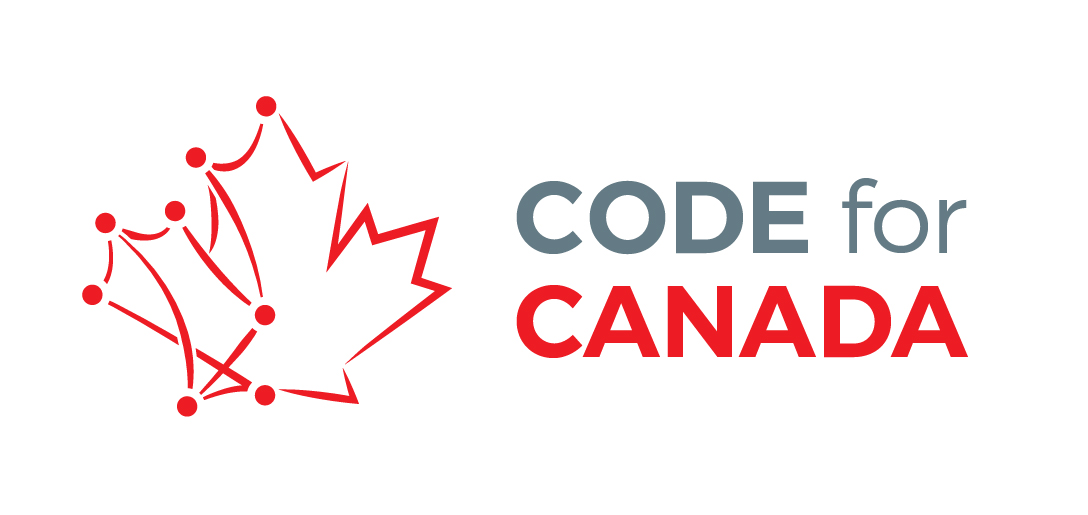

## Connect on LinkedIn
https://www.linkedin.com/in/dwight-gunning-860124/

## Vote for the kernel
If you have made it this far - please vote for the kernel. Thank you!

# References
- [Wikipedia article on Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25)
- [The rank_bm25 python library](https://pypi.org/project/rank-bm25/)
- [Discussion on CORD Dataset Changes](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/137474)